In [18]:
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import os


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

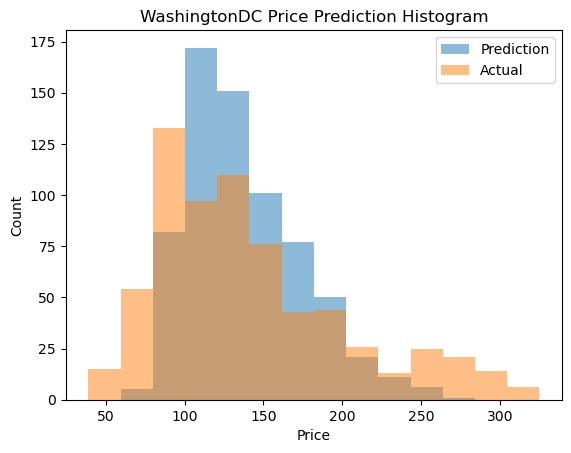

In [44]:
city = 'WashingtonDC'

param = {
    'n_estimators': 200,
    'max_depth': 11,
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

results = {}

listings = pd.read_csv(f'./data/{city}/data_cleaned.csv')
# listings = pd.read_csv('./data/WashingtonDC/listings.csv')
df = listings.copy()

df['price_num'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
df['host_response_rate'] = df['host_response_rate'].replace({np.nan:0})

df['taken_30'] = 30-df['availability_30']
df['taken_60'] = 60-df['availability_60']

df['sales_30'] = df['taken_30'] * df['price_num']
df['sales_60'] = df['taken_60'] * df['price_num']

# Column types
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

specific_date = pd.to_datetime('2024-04-04')
df['host_days_since'] = (specific_date - df['host_since']).dt.days

df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']] = df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']].replace({'t': 1, 'f': 0})
df[['host_response_time']] = df[['host_response_time']].replace({np.nan: 0, 'within a few hours': 3, 'within an hour': 4, 'within a day': 2, 'a few days or more': 1})

# df['host_desc_len'] = [0 if pd.isna(i) else len(i) for i in df['host_about']]

# Calculate Q1 (25th percentile of the data) for the 'price' column
Q1 = df['price_num'].quantile(0.25)

# Calculate Q3 (75th percentile of the data) for the 'price' column
Q3 = df['price_num'].quantile(0.75)

# Calculate the IQR by subtracting Q1 from Q3
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_filtered = df[(df['price_num'] <= upper_bound)]



top_10 = df_filtered['neighbourhood_cleansed'].value_counts().keys()
# top_10 = df_filtered['neighbourhood_cleansed'].value_counts().head(10).keys()
top10_df = df_filtered[df_filtered['neighbourhood_cleansed'].isin(top_10)]
temp = top10_df[top10_df['neighbourhood_cleansed'].isin(top_10)]
temp = temp[temp['property_type'].str.contains('entire', case=False, na=False)]

df_num = temp[['price_num','host_response_rate','instant_bookable','host_listings_count','host_total_listings_count','host_response_time','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','latitude','longitude','accommodates','beds','minimum_nights','maximum_nights','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_days_since','neighbourhood_cleansed']]

df_num_drop = df_num.dropna()

# 1. Separate the 'neighbourhood_cleansed' column from the rest of the DataFrame
numerical = ['price_num','neighbourhood_cleansed','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','host_response_time']

numerical_features = df_num_drop.drop(numerical, axis=1)
non_numerical_feature = df_num_drop[numerical]

# 2. Scale only the numerical columns
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)
df_numerical_scaled = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)

# 3. Concatenate the scaled numerical columns and the 'non-numerical' columns
df_standardized = pd.concat([df_numerical_scaled, non_numerical_feature.reset_index(drop=True)], axis=1)
df_standardized = pd.get_dummies(df_standardized, columns=['neighbourhood_cleansed'])



# Split data into training and testing sets
X = df_standardized.drop(columns=['price_num'])
y = df_standardized['price_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(**param, random_state=42)
model.fit(X_train, y_train)

# Print feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# print("Top 10 Feature Importances:\n", feature_importances[:10])

# Make predictions on the test set
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

# Calculate and print the metrics
test_mse = mean_squared_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)

test_r2 = r2_score(y_test, test_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Determine the common range for the histograms
bin_min = min(min(test_predictions), min(y_test))  # Lowest value between both
bin_max = max(max(test_predictions), max(y_test))  # Highest value between both

# Define the number of bins or the bin width you desire
number_of_bins = 15  # For example, 30 bins
# Or

# If using number of bins directly:
bins = np.linspace(bin_min, bin_max, number_of_bins)

plt.title(f'{city} Price Prediction Histogram')
plt.xlabel('Price')
plt.ylabel('Count')
plt.hist(test_predictions, alpha = 0.5, bins = bins, label = 'Prediction')
plt.hist(y_test, alpha = 0.5, bins = bins, label = 'Actual')
plt.legend()
plt.savefig(f'./{city}_histogram.png')
plt.show()

In [20]:
def RandomForestRegression(directory, param):
    # listings = pd.read_csv('./data/WashingtonDC/listings.csv')
    listings = pd.read_csv(directory)
    df = listings.copy()

    df['price_num'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
    df['host_response_rate'] = df['host_response_rate'].replace({np.nan:0})

    df['taken_30'] = 30-df['availability_30']
    df['taken_60'] = 60-df['availability_60']

    df['sales_30'] = df['taken_30'] * df['price_num']
    df['sales_60'] = df['taken_60'] * df['price_num']

    # Column types
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['last_review'] = pd.to_datetime(df['last_review'])

    specific_date = pd.to_datetime('2024-04-04')
    df['host_days_since'] = (specific_date - df['host_since']).dt.days

    df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']] = df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']].replace({'t': 1, 'f': 0})
    df[['host_response_time']] = df[['host_response_time']].replace({np.nan: 0, 'within a few hours': 3, 'within an hour': 4, 'within a day': 2, 'a few days or more': 1})

    # df['host_desc_len'] = [0 if pd.isna(i) else len(i) for i in df['host_about']]

    # Calculate Q1 (25th percentile of the data) for the 'price' column
    Q1 = df['price_num'].quantile(0.25)

    # Calculate Q3 (75th percentile of the data) for the 'price' column
    Q3 = df['price_num'].quantile(0.75)

    # Calculate the IQR by subtracting Q1 from Q3
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_filtered = df[(df['price_num'] <= upper_bound)]

    top_10 = df_filtered['neighbourhood_cleansed'].value_counts().keys()
    # top_10 = df_filtered['neighbourhood_cleansed'].value_counts().head(10).keys()
    top10_df = df_filtered[df_filtered['neighbourhood_cleansed'].isin(top_10)]
    temp = top10_df[top10_df['neighbourhood_cleansed'].isin(top_10)]
    temp = temp[temp['property_type'].str.contains('entire', case=False, na=False)]

    df_num = temp[['price_num','host_response_rate','instant_bookable','host_listings_count','host_total_listings_count','host_response_time','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','latitude','longitude','accommodates','beds','minimum_nights','maximum_nights','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_days_since','neighbourhood_cleansed']]

    df_num_drop = df_num.dropna()

    # 1. Separate the 'neighbourhood_cleansed' column from the rest of the DataFrame
    numerical = ['price_num','neighbourhood_cleansed','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','host_response_time']

    numerical_features = df_num_drop.drop(numerical, axis=1)
    non_numerical_feature = df_num_drop[numerical]

    # 2. Scale only the numerical columns
    scaler = StandardScaler()
    numerical_features_scaled = scaler.fit_transform(numerical_features)
    df_numerical_scaled = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)

    # 3. Concatenate the scaled numerical columns and the 'non-numerical' columns
    df_standardized = pd.concat([df_numerical_scaled, non_numerical_feature.reset_index(drop=True)], axis=1)
    df_standardized = pd.get_dummies(df_standardized, columns=['neighbourhood_cleansed'])
    

    # Split data into training and testing sets
    X = df_standardized.drop(columns=['price_num'])
    y = df_standardized['price_num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    # Print feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    # print("Top 10 Feature Importances:\n", feature_importances[:10])

    # Make predictions on the test set
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)

    # Calculate and print the metrics
    test_mse = mean_squared_error(y_test, test_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)

    test_r2 = r2_score(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    return feature_importances, train_r2, test_r2, train_mse, test_mse, model, 

In [21]:
directory_path = './data/'
entries = os.listdir('./data/')

params = {
    'n_estimators': 200,
    'max_depth': 11,
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

results = {}

# Loop over each entry and check if it is a directory
for entry in entries:
    full_path = os.path.join(directory_path, entry)
    full_path = full_path + '/data_cleaned.csv'

    feature, train_r2, test_r2, train_mse, test_mse, model = RandomForestRegression(full_path,params)

    results[entry] = {}
    results[entry]['feature_importance'] = feature
    results[entry]['train_r2'] = train_r2
    results[entry]['test_r2'] = test_r2
    results[entry]['train_mse'] = train_mse
    results[entry]['test_mse'] = test_mse
    results[entry]['model'] = model

    print(f"{entry} complete")


Athens complete
Austin complete
Bangkok complete
Barcelona complete
Boston complete
Hawaii complete
LosAngeles complete
MexicoCity complete
NewYork complete
Paris complete
Rome complete
Seattle complete
Singapore complete
WashingtonDC complete


In [22]:
test_mse = [(i,np.sqrt(results[i]['test_mse'])) for i in results]
test_mse

[('Athens', 25.00423284005543),
 ('Austin', 64.52210290955674),
 ('Bangkok', 132.70311724482357),
 ('Barcelona', 33.114940780075734),
 ('Boston', 59.744446725224975),
 ('Hawaii', 86.94059773983115),
 ('LosAngeles', 62.527713990906406),
 ('MexicoCity', 142.23128356541875),
 ('NewYork', 62.31248584793697),
 ('Paris', 51.0240683608615),
 ('Rome', 41.15223530652953),
 ('Seattle', 45.71573533611363),
 ('Singapore', 83.09709029661124),
 ('WashingtonDC', 45.523118749781524)]

In [23]:
train_mse = [(i,np.sqrt(results[i]['train_mse'])) for i in results]
train_mse

[('Athens', 16.030772875447376),
 ('Austin', 40.956499870468534),
 ('Bangkok', 70.56512316916931),
 ('Barcelona', 21.744164240614428),
 ('Boston', 29.62480671233815),
 ('Hawaii', 68.92281206700633),
 ('LosAngeles', 48.53511552562788),
 ('MexicoCity', 97.49669585246227),
 ('NewYork', 46.52881504858571),
 ('Paris', 43.613816744398456),
 ('Rome', 30.498215326542876),
 ('Seattle', 27.12795116034988),
 ('Singapore', 43.32279370325034),
 ('WashingtonDC', 26.005219297710894)]

In [24]:
test_r2 = [(i,results[i]['test_r2']) for i in results]
test_r2

[('Athens', 0.43618478040929065),
 ('Austin', 0.5070771301835859),
 ('Bangkok', 0.312475220030484),
 ('Barcelona', 0.49551286889437196),
 ('Boston', 0.4793169680213235),
 ('Hawaii', 0.5853540052121047),
 ('LosAngeles', 0.5117297719342153),
 ('MexicoCity', 0.3385634444334662),
 ('NewYork', 0.42325266679051954),
 ('Paris', 0.48705859833970777),
 ('Rome', 0.41696520539802007),
 ('Seattle', 0.44506748139753605),
 ('Singapore', 0.6008928541560609),
 ('WashingtonDC', 0.42145299321209384)]

In [25]:
train_r2 = [(i,results[i]['train_r2']) for i in results]
train_r2

[('Athens', 0.7626471910752671),
 ('Austin', 0.7998601449459566),
 ('Bangkok', 0.7912012910830923),
 ('Barcelona', 0.7888126641208983),
 ('Boston', 0.8524251734391429),
 ('Hawaii', 0.7304414503090939),
 ('LosAngeles', 0.6953007934492696),
 ('MexicoCity', 0.7043433491447175),
 ('NewYork', 0.699991461157585),
 ('Paris', 0.6220713123821484),
 ('Rome', 0.6790923718949307),
 ('Seattle', 0.8091109622208366),
 ('Singapore', 0.8920333643331394),
 ('WashingtonDC', 0.8082954411082812)]

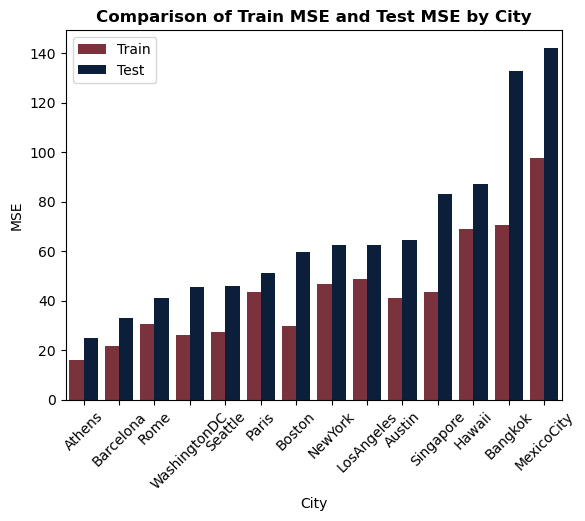

In [26]:
test_mse = [np.sqrt(results[i]['test_mse']) for i in results]
train_mse = [np.sqrt(results[i]['train_mse']) for i in results]
keys = [i for i in results]


df = pd.DataFrame(list(zip(keys,train_mse,test_mse)),columns=['City','Train','Test'])

sorted_cities = df.sort_values('Test')['City'].tolist()

df_long = df.melt(id_vars='City', var_name='Type', value_name='MSE')
# Create the barplot with dodged bars
palette = sns.color_palette("pastel")
custom_palette = ['#862633','#041e42'] 

sns.barplot(x='City', y='MSE', hue='Type', data=df_long, dodge=True, order=sorted_cities, palette = custom_palette)

# Customize the plot
plt.title('Comparison of Train MSE and Test MSE by City',  fontweight = 'bold')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.xlabel('City')
plt.ylabel('MSE')
plt.legend()
plt.savefig('./MSE.png', dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG with high resolution


plt.show()

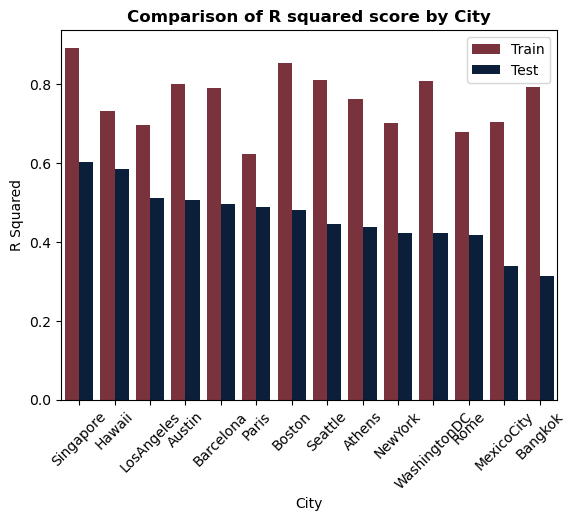

In [27]:
test_r2 = [(results[i]['test_r2']) for i in results]
train_r2 = [(results[i]['train_r2']) for i in results]
keys = [i for i in results]

df = pd.DataFrame(list(zip(keys,train_r2,test_r2)),columns=['City','Train','Test'])
sorted_cities = df.sort_values('Test', ascending=False)['City'].tolist()
df_long = df.melt(id_vars='City', var_name='Type', value_name='R Squared')
# Create the barplot with dodged bars
palette = sns.color_palette("pastel")
custom_palette = ['#862633','#041e42'] 
sns.barplot(x='City', y='R Squared', hue='Type', data=df_long, dodge=True, order=sorted_cities,palette=custom_palette)

# Customize the plot
plt.title('Comparison of R squared score by City', fontweight = 'bold')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.xlabel('City')
plt.ylabel('R Squared')
plt.legend()
plt.savefig('./R2.png', dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG with high resolution

plt.show()

In [28]:
sorted_list = sorted([(i, results[i]['test_r2']) for i in results], key=lambda x: x[1], reverse=True)
sorted_list

[('Singapore', 0.6008928541560609),
 ('Hawaii', 0.5853540052121047),
 ('LosAngeles', 0.5117297719342153),
 ('Austin', 0.5070771301835859),
 ('Barcelona', 0.49551286889437196),
 ('Paris', 0.48705859833970777),
 ('Boston', 0.4793169680213235),
 ('Seattle', 0.44506748139753605),
 ('Athens', 0.43618478040929065),
 ('NewYork', 0.42325266679051954),
 ('WashingtonDC', 0.42145299321209384),
 ('Rome', 0.41696520539802007),
 ('MexicoCity', 0.3385634444334662),
 ('Bangkok', 0.312475220030484)]

In [29]:
[(i,results[i]['feature_importance'][:10]) for i in results]

[('Athens',
  accommodates                 0.217926
  latitude                     0.199881
  review_scores_location       0.052155
  longitude                    0.051477
  reviews_per_month            0.048986
  host_days_since              0.046171
  review_scores_rating         0.035369
  review_scores_cleanliness    0.030020
  number_of_reviews            0.026115
  number_of_reviews_ltm        0.023885
  dtype: float64),
 ('Austin',
  beds                         0.192256
  accommodates                 0.164342
  reviews_per_month            0.129557
  host_days_since              0.046693
  longitude                    0.045454
  latitude                     0.043268
  review_scores_location       0.037148
  minimum_nights               0.033755
  maximum_nights               0.022513
  review_scores_cleanliness    0.022354
  dtype: float64),
 ('Bangkok',
  longitude                    0.151880
  latitude                     0.144793
  host_days_since              0.091152
  min

In [30]:
results['Rome']['feature_importance'][:10]

accommodates                               0.237720
review_scores_location                     0.095786
longitude                                  0.083118
neighbourhood_cleansed_I Centro Storico    0.080396
number_of_reviews_l30d                     0.064272
latitude                                   0.056477
reviews_per_month                          0.043264
host_days_since                            0.036807
number_of_reviews                          0.032175
review_scores_rating                       0.032108
dtype: float64

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
feature_importance = [(i,results[i]['feature_importance'][:10]) for i in results]

In [33]:
results['WashingtonDC']['feature_importance'].keys()

Index(['accommodates', 'review_scores_location', 'longitude', 'latitude',
       'reviews_per_month', 'host_days_since', 'number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'number_of_reviews_ltm', 'review_scores_accuracy',
       'review_scores_value', 'minimum_nights', 'maximum_nights',
       'review_scores_checkin', 'review_scores_communication', 'beds',
       'host_total_listings_count',
       'calculated_host_listings_count_entire_homes', 'host_listings_count',
       'number_of_reviews_l30d', 'calculated_host_listings_count',
       'host_response_time', 'host_response_rate',
       'calculated_host_listings_count_private_rooms',
       'host_identity_verified',
       'neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street',
       'host_is_superhost', 'neighbourhood_cleansed_Near Southeast, Navy Yard',
       'neighbourhood_cleansed_Union Station, Stanton Park, Kingman Park',
       'neighbourh

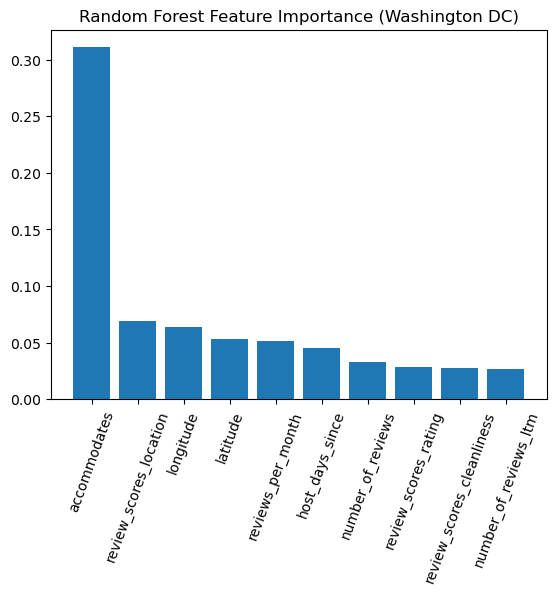

In [34]:
plt.bar(x = results['WashingtonDC']['feature_importance'].keys()[0:10],height = results['WashingtonDC']['feature_importance'].values[0:10])
plt.xticks(rotation = 70)
plt.title("Random Forest Feature Importance (Washington DC)")
plt.show()
# plt.plot(results['Singapore']['feature_importance'].values[1:])

In [35]:
import pandas as pd
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score


def datacleaner(directory):
    # listings = pd.read_csv('./data/WashingtonDC/listings.csv')
    listings = pd.read_csv(directory)
    df = listings.copy()

    df['price_num'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
    df['host_response_rate'] = df['host_response_rate'].replace({np.nan:0})

    df['taken_30'] = 30-df['availability_30']
    df['taken_60'] = 60-df['availability_60']

    df['sales_30'] = df['taken_30'] * df['price_num']
    df['sales_60'] = df['taken_60'] * df['price_num']

    # Column types
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['last_review'] = pd.to_datetime(df['last_review'])

    specific_date = pd.to_datetime('2024-04-04')
    df['host_days_since'] = (specific_date - df['host_since']).dt.days

    df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']] = df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']].replace({'t': 1, 'f': 0})
    df[['host_response_time']] = df[['host_response_time']].replace({np.nan: 0, 'within a few hours': 3, 'within an hour': 4, 'within a day': 2, 'a few days or more': 1})

    # df['host_desc_len'] = [0 if pd.isna(i) else len(i) for i in df['host_about']]

    # Calculate Q1 (25th percentile of the data) for the 'price' column
    Q1 = df['price_num'].quantile(0.25)

    # Calculate Q3 (75th percentile of the data) for the 'price' column
    Q3 = df['price_num'].quantile(0.75)

    # Calculate the IQR by subtracting Q1 from Q3
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_filtered = df[(df['price_num'] <= upper_bound)]

    top_10 = df_filtered['neighbourhood_cleansed'].value_counts().head(10).keys()
    # top_10 = df_filtered['neighbourhood_cleansed'].value_counts().head(10).keys()
    top10_df = df_filtered[df_filtered['neighbourhood_cleansed'].isin(top_10)]
    temp = top10_df[top10_df['neighbourhood_cleansed'].isin(top_10)]
    temp = temp[temp['property_type'].str.contains('entire', case=False, na=False)]

    df_num = temp[['price_num','bathrooms','host_response_rate','instant_bookable','host_listings_count','host_total_listings_count','host_response_time','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','latitude','longitude','accommodates','beds','minimum_nights','maximum_nights','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_days_since','neighbourhood_cleansed']]

    df_num_drop = df_num.dropna()

    # 1. Separate the 'neighbourhood_cleansed' column from the rest of the DataFrame
    numerical = ['price_num','neighbourhood_cleansed','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','host_response_time']

    numerical_features = df_num_drop.drop(numerical, axis=1)
    non_numerical_feature = df_num_drop[numerical]

    # 2. Scale only the numerical columns
    scaler = StandardScaler()
    numerical_features_scaled = scaler.fit_transform(numerical_features)
    df_numerical_scaled = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)

    # 3. Concatenate the scaled numerical columns and the 'non-numerical' columns
    df_standardized = pd.concat([df_numerical_scaled, non_numerical_feature.reset_index(drop=True)], axis=1)
    df_standardized = pd.get_dummies(df_standardized, columns=['neighbourhood_cleansed'])
    


    # Split data into training and testing sets
    X = df_standardized.drop(columns=['price_num'])
    y = df_standardized['price_num']

    for col in X.select_dtypes(include=['bool']).columns:
        X[col] = X[col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [36]:
directory_path = './data/'
entries = os.listdir('./data/')

results = {}

# Loop over each entry and check if it is a directory
for entry in entries:
    full_path = os.path.join(directory_path, entry)
    full_path = full_path + '/data_cleaned.csv'

    X_train, X_test, y_train, y_test = datacleaner(full_path)

    result = stepwise_selection(X_train, y_train, verbose=False)

    X_train = X_train[result]
    X_test = X_test[result]

    model = sm.OLS(y_train, X_train).fit()

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[entry] = {}
    results[entry]['model'] = model
    results[entry]['test_r2'] = r2
    results[entry]['test_mse'] = mse

    print(f"{entry} complete")



Athens complete
Austin complete
Bangkok complete
Barcelona complete
Boston complete
Hawaii complete
LosAngeles complete
MexicoCity complete
NewYork complete
Paris complete
Rome complete
Seattle complete
Singapore complete
WashingtonDC complete


In [37]:
results['Rome']['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_num   R-squared (uncentered):                   0.839
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                              2664.
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                        0.00
Time:                        15:14:19   Log-Likelihood:                         -63951.
No. Observations:               11818   AIC:                                  1.279e+05
Df Residuals:                   11795   BIC:                                  1.281e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
accommodates                                          9.2305      0.868     10.633      0.000       7.529      10.932
neighbourhood_cleansed_I Centro Storico             131.1997      0.866    151.474      0.000     129.502     132.897
bathrooms                                            13.2133      0.617     21.432      0.000      12.005      14.422
number_of_reviews_l30d                               -6.7888      0.676    -10.035      0.000      -8.115      -5.463
review_scores_location                               -6.1033      0.666     -9.162      0.000      -7.409      -4.798
neighbourhood_cleansed_X Ostia/Acilia                -0.8687      4.634     -0.187      0.851      -9.952       8.215
reviews_per_month                                    -9.6581      0.708    -13.641      0.000     -11.046      -8.270
host_is_superhost                                    28.0464      1.093     25.660      0.000      25.904      30.189
number_of_reviews                                    -7.8408      0.589    -13.302      0.000      -8.996      -6.685
neighbourhood_cleansed_II Parioli/Nomentano         112.5526      2.085     53.972      0.000     108.465     116.640
calculated_host_listings_count_entire_homes          -2.4860      0.512     -4.852      0.000      -3.490      -1.482
neighbourhood_cleansed_XIII Aurelia                  84.8468      2.082     40.756      0.000      80.766      88.927
review_scores_cleanliness                             2.2509      0.883      2.550      0.011       0.521       3.981
review_scores_communication                          -2.2014      0.781     -2.817      0.005      -3.733      -0.670
minimum_nights                                       -1.3935      0.462     -3.015      0.003      -2.299      -0.487
neighbourhood_cleansed_V Prenestino/Centocelle       99.4929      3.000     33.167      0.000      93.613     105.373
review_scores_rating                                  9.3024      1.330      6.994      0.000       6.695      11.910
review_scores_accuracy                               -2.3239      1.082     -2.148      0.032      -4.445      -0.203
beds                                                  3.5893      0.818      4.390      0.000       1.987       5.192
review_scores_value                                  -1.5962      1.081     -1.476      0.140      -3.715       0.523
neighbourhood_cleansed_VII San Giovanni/Cinecittà   106.7105      2.343     45.541      0.000     102.117     111.303
longitude                                           -18.0294      1.034    -17.431      0.000     -20.057     -16.002
maximum_nights                    

In [38]:
directory = './data/WashingtonDC/data_cleaned.csv'
X_train, X_test, y_train, y_test = datacleaner(directory)

result = stepwise_selection(X_train, y_train, verbose=False)

In [39]:
X_train = X_train[result]
X_test = X_test[result]

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the linear regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict the values of y using the test set
y_pred = lr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')


Mean Squared Error: 2188.05
R^2 Score: 0.36


In [41]:
import statsmodels.api as sm

# Assuming 'X' contains the features selected by the stepwise regression, and 'y' is the target variable
# Add a constant to the model (the intercept term)

# Create the model
model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              price_num   R-squared (uncentered):                   0.850
Model:                            OLS   Adj. R-squared (uncentered):              0.848
Method:                 Least Squares   F-statistic:                              585.9
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                        0.00
Time:                        15:14:23   Log-Likelihood:                         -10347.
No. Observations:                1884   AIC:                                  2.073e+04
Df Residuals:                    1866   BIC:                                  2.083e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                                                                                        coef    std err          t      